# Theoretical & Empirical analysis of Expected Sarsa

The theoretical analysis component presented is a review of Section 5 from [A Theoretical and Empirical Analysis of Expected Sarsa, van Seijen, van Hasselt, Whiteson, and Weiring (2009)](http://webdocs.cs.ualberta.ca/~vanseije/resources/papers/vanseijenadprl09.pdf)

I later show the empirically the differences between Expected Sarsa, 'Traditional Sarsa' and Q-learning for a given experiment.

#### Background

The traditional Sarsa method is a on-policy that updates the action-value function. The principal caracteristic of this approach is that it uses both the sampled action and state to perform the update. Its update rule can be detailed as

$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha [r_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)]$

We can refer to $r_t + \gamma Q(s_{t+1}, a_{t+1})$ as a component of the Temporal Difference and note it as $v^{TS}_t$. The above update rule can therefore be rewritten as

$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha [v^{TS}_t - Q(s_t, a_t)]$.

#### Expected Sarsa

Expected Sarsa is very similar to Traditional Sarsa, but in order to perform the update, it only samples the state. We can therefore write it as,

$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha [v^{ES}_t - Q(s_t, a_t)]$, where

$v^{ES}_t = r_t + \gamma \sum_a \pi_t(s_{t+1}, a) Q(s_{t+1}, a)$.

This approach incorporates all the possible actions after the sampled state in order to update the action-value function. In other words, the expected state-value.


### Theoretical Variance analysis

Here we analyse the difference in variance for the traditional Sarsa and Expected Sarsa methods.

In order to analyse variance, the article uses targets as the Temporal Difference (TD) component of the action-value update rule $v^{ES}_t$ and $v^{TS}_t$ (as defined earlier), for Expected Sarsa and Traditional Sarsa, respectively.

$v^{ES}_t = r_t + \gamma \sum_a \pi_t(s_{t+1}, a) Q(s_{t+1}, a)$

$v^{TS}_t = r_t + \gamma Q(s_{t+1}, a_{t+1})$

Given they have both the same expected value at convergence, using the variance formula $\text{Var}(s, a) = E[X_t^2] - E[X_t]^2$ and the above mentionned targets, we can write the variance of the Traditional Sarsa,

$\text{Var}(v^{TS}_t) = \sum_{s'} T^{s'}_{sa} \Big( \gamma^2 \sum_{a'} \pi_t(s', a') Q_t(s', a')^2 + [R^{s'}_{sa}]^2 + 2 \gamma R^{s'}_{sa} \sum_{a'} \pi_{s'a'}(Q_t(s', a')) \Big) - E[v^{TS}_t]^2$


An the variance of the Expected Sarsa,

$\text{Var}(v^{ES}_t) = \sum_{s'} T^{s'}_{sa} \Big( \gamma^2 \big( \sum_{a'} \pi_t(s', a') Q_t(s', a') \big )^2 + [R^{s'}_{sa}]^2 + 2 \gamma R^{s'}_{sa} \sum_{a'} \pi_{s'a'}(Q_t(s', a')) \Big) - E[v^{ES}_t]^2$

Since $E[v^{ES}_t] = E[v^{TS}_t]$ we can focus on the difference between both variances $\text{Var}(v^{TS}_t)$ and $\text{Var}(v^{ES}_t)$ as

$\gamma^2 \sum_{s'} T^{s'}_{sa} \Big( \sum_{a'} \pi_t(s', a') Q_t(s', a')^2 - \big( \sum_{a'} \pi_t(s', a') Q_t(s', a') \big )^2 \Big)$

We can notice that the above equation ressembles the variance formula where the weight is $\pi_t(s', a')$ and the value observed is $Q_t(s', a')$.

$\sum_i w_i x_i^2 - (\sum_i w_i x_i)^2$

Under this observation, the article expands on the idea that as we recognize this as a variance calculation, it will always be greater than 0.

We can therefore conclude that $\text{Var}(v^{TS}_t) \ge \text{Var}(v^{ES}_t)$.

### Empirical analysis

In this section I will move to an empirical analysis of Expected Sarsa, Traditional Sarsa as well as Q-learning. The three methods were trained with the same parameters.

#### Environment

The environment explored will be of a gridworld type, with water hazards. The goal is simply to reach the cell noted as G. In this experiment, the agent can control both its horizontal and vertical velocity. However, some restrictions do apply (i.e. cannot go backwards, so only towards the right, but can turn right or left).

Furthermore, we restrict the agent not to have both horizontal and vertical velocity at zero, unless it is at the starting position. If the car hits either out of bounds or a water hazard, it is replaced at the starting line. The rewards are -10 for a water hazard, 0 for the finish line and -1 for anything else. When an action is selected, there is also a 10% chance that it is not applied and therefore both horizontal and vertical velocities are maintained.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import collections
import pandas
State = collections.namedtuple('State', ['row', 'col', 'hori', 'vert'])

def movingAverage(interval, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(interval, window, mode='same')

We now set up the world in which the car/agent will operate. In addition, we initialize the state space, the actions and the action-value functions (to 0).

We defined different worlds for different experiments that vary in difficulty.

In [2]:
def initWorld():
    """
    Initializes a world
    ---
    Returns:    world as a matrix, start_position as tuple
    'S'         denotes start
    'G'         denotes goal
    '-'         denotes the road
    'W'         denotes water
    """
    world = [['-','-','-','-','-','-','-','-','-','-','-','-','-'],
             ['-','-','-','-','-','-','-','-','-','-','-','-','-'],
             ['-','-','-','-','-','-','-','-','-','-','-','-','-'],
             ['-','-','-','-','-','-','-','-','-','-','-','-','-'],
             ['-','-','-','-','-','-','W','W','W','-','-','-','-'],
             ['-','-','-','-','-','W','W','W','W','W','-','-','-'],
             ['-','-','-','-','W','W','W','W','W','W','-','-','-'],
             ['-','-','-','W','W','W','W','W','W','W','-','-','-'],
             ['-','-','W','W','W','W','W','W','W','W','-','-','-'],
             ['S','-','W','W','W','W','W','W','W','W','-','-','G']]
    
    start_position = (9, 0)
    
    return np.matrix(world), start_position


def initTinyWorld():
    """
    Initializes a world
    ---
    Returns:    world as a matrix, start_position as tuple
    'S'         denotes start
    'G'         denotes goal
    '-'         denotes the road
    'W'         denotes water
    """
    world = [['-','-','-','-','-','-','-','-','-','-'],
             ['-','-','-','-','-','-','-','-','-','-'],
             ['-','-','-','-','-','-','-','-','-','-'],
             ['-','-','-','-','-','W','W','-','-','-'],
             ['-','-','-','-','W','W','W','-','-','-'],
             ['-','-','-','W','W','W','W','-','-','-'],
             ['-','-','W','W','W','W','W','-','-','-'],
             ['S','-','W','W','W','W','W','-','-','G']]
    
    start_position = (7, 0)
    
    return np.matrix(world), start_position


def initVeryTinyWorld():
    """
    Initializes a world
    ---
    Returns:    world as a matrix, start_position as tuple
    'S'         denotes start
    'G'         denotes goal
    '-'         denotes the road
    'W'         denotes water
    """
    world = [['-','-','-','-','-','-','-','-','-','-'],
             ['-','-','-','-','-','-','-','-','-','-'],
             ['-','-','-','-','-','-','-','-','-','-'],
             ['-','-','-','-','-','-','-','-','-','-'],
             ['-','-','-','-','-','W','W','-','-','-'],
             ['-','-','-','-','-','W','W','-','-','-'],
             ['-','-','-','-','-','W','W','-','-','-'],
             ['-','-','-','-','-','W','W','-','-','-'],
             ['-','-','-','-','-','W','W','-','-','-'],
             ['S','-','-','-','-','W','W','-','-','G']]
    
    start_position = (9, 0)
    
    return np.matrix(world), start_position

def initWorld2():
    """
    Initializes a world
    ---
    Returns:    world as a matrix, start_position as tuple
    'S'         denotes start
    'G'         denotes goal
    '-'         denotes the road
    'W'         denotes water
    """
    world = [['-','-','-','-','-','-','-','W','W','W','W','W','G'],
             ['-','-','-','-','-','-','-','W','W','W','W','W','-'],
             ['-','-','-','-','-','-','-','W','W','W','W','-','-'],
             ['-','-','-','-','-','-','-','-','W','W','W','-','-'],
             ['-','-','-','W','W','-','-','-','W','W','W','-','-'],
             ['-','-','W','W','W','-','-','-','-','-','-','-','-'],
             ['-','-','W','W','W','-','-','-','-','-','-','-','W'],
             ['-','-','W','W','W','W','W','-','-','-','-','W','W'],
             ['-','-','W','W','W','W','W','W','W','W','W','W','W'],
             ['S','-','W','W','W','W','W','W','W','W','W','W','W']]
    
    start_position = (9, 0)
    
    return np.matrix(world), start_position


def initStateActions(world):
    """
    Initialize State, Actions and Q_sa values for a given world
    ---
    returns states, actions, Q_sa
    """
    # Initialize actions
    # Define the 9 possible actions
    # Help the car by letting the default one be increase horizontal
    actions = [0, #('car.incr_hori', '')
               1, #('car.incr_vert, car.incr_hori')
               2, #('car.incr_vert, car.decr_hori')
               3, #('car.decr_vert, car.incr_hori')
               4, #('car.incr_vert', '')
               5, #('car.decr_vert', '')
               6, #('car.decr_vert, car.decr_hori')
               7, #('car.decr_hori', '')
               8] #

    # Create the states
    # State = the car. pos (row, col), hori & vert velocity
    states = []
    velo_verts = [x for x in xrange(-5, 6)]
    velo_horis = [x for x in xrange(0, 6)]
    for row in xrange(world.shape[0]):
        for col in xrange(world.shape[1]):
            for velo_hori in velo_horis:
                for velo_vert in velo_verts:
                    state = State(row, col, velo_hori, velo_vert)
                    states.append(state)


    # Create Q(s, a), the value of a state-action pair
    # We also initialize it at 0 as an arbitrary decision.
    # Set it up as a dictionnary so we will be able to look it up directly
    Q_sa = {}
    old_Q_sa = {}
    counter_sa = {}
    returns_sa = {}
    for state in states:
        for action in actions:
            Q_sa[(state, action)] = 0
            counter_sa[(state, action)] = 0
            returns_sa[(state, action)] = 0
    
    return states, actions, Q_sa

#### Implementing the agent

Now we need to implement everything that relates to the actual agent, the racecar in this case.

In [3]:
class RaceCar:
    def __init__(self, world, start_pos, max_velo=5):
        """
        Initialize the RaceCar with initial position. Velocities will be set 0
        """
        self.pos_row = start_pos[0]
        self.pos_col = start_pos[1]
        self.velo_vert = 0
        self.velo_hori = 0
        self.max_velo = max_velo

    def incr_vert(self):
        """
        Increases vertical velocity by 1 (not more than max_velo)
        """
        self.velo_vert = min(self.velo_vert + 1, self.max_velo)

    def decr_vert(self):
        """
        Decreases vertical velocity by 1 (not less than -5)
        """
        self.velo_vert = max(self.velo_vert - 1, -self.max_velo)

    def incr_hori(self):
        """
        Increases horizontal velocity by 1 (not more than 5)
        """
        self.velo_hori = min(self.velo_hori + 1, self.max_velo)

    def decr_hori(self):
        """
        Decreases horizontal velocity by 1 (not less than 0)
        """
        self.velo_hori = max(self.velo_hori - 1, 0)

    def reset(self, world, start_pos):
        """
        Resets the car at the starting position with no velocity
        """
        self.__init__(world, start_pos)
        
    def __str__(self):
        return 'position\t [%s, %s]\nvelocity h\t %s \nvelocity v\t %s' \
                %(self.pos_row, self.pos_col, self.velo_hori, self.velo_vert)


def moveCar(car, world, start_position):
    """
    Moves the car. If moves out of bounds, is replaced on start_line.
    ---
    world: Matrix with the world
    """
    
    row_prime = car.pos_row - car.velo_vert
    col_prime = car.pos_col + car.velo_hori

    if row_prime < 0 or col_prime < 0:
        out_of_bounds = True
    elif row_prime > world.shape[0] - 1:
        out_of_bounds = True
    elif col_prime > world.shape[1] - 1:
        out_of_bounds = True
    elif world[row_prime, col_prime] == 'W':
        out_of_bounds = True
    else:
        out_of_bounds = False
    
    if out_of_bounds:
        # if out of bounds reset the car to start
        car.reset(world, start_position)
    else:
        # if not out of bounds, determine new position
        car.pos_row = row_prime
        car.pos_col = col_prime

We now set up the methods that will be used by our RL algorithm:

In [4]:
def getGreedyAction(Q_sa, state, actions):
    """
    Returns the action that has the highest value for a given state
    """
    temp = []
    
    for action in actions:
        temp.append(Q_sa[(state, action)])
    return np.argmax(temp)
    

def getReward(state, world):
    """
    Returns a reward based on the state the agent is in
    """
    if world[state.row, state.col] == 'G':
        return 0
    elif world[state.row, state.col] == 'W':
        return -100
    else:
        return -1
    
def executeAction(car, action):
    """
    Executes the action based on the action mapped.
    Some conditionning is made in order to ensure
    the car doesn't become stationary.
    ---
    action as integer
    """
    if action == 6:
        if not (car.velo_hori <= 1 and car.velo_vert == 1):
            car.decr_hori()
            car.decr_vert()
    elif action == 1:
        car.incr_hori()
        car.incr_vert()
    elif action == 2:
        if not (car.velo_hori <= 1 and car.velo_vert == -1):
            car.decr_hori()
            car.incr_vert()
    elif action == 3:
        if not (car.velo_hori == 0 and car.velo_vert == 1):
            car.incr_hori()
            car.decr_vert()
    elif action == 4:
        if not(car.velo_hori == 0 and car.velo_vert == -1):
            car.incr_vert()
    elif action == 5:
        if not (car.velo_hori == 0 and car.velo_vert == 1):
            car.decr_vert()
    elif action == 0:
        car.incr_hori()
    elif action == 7:
        if not (car.velo_hori <= 1 and car.velo_vert == 0):
            car.decr_hori()
    return

In [5]:
def genSarsaEpisode(world, start_position, car, Q_sa, actions, learn_rate=0.05,
                    gamma=1, epsilon=0.1, expectedSarsa=False, Qlearning=False,
                    FirstEpisode=False, Unlucky=True, debug=False):
    
    if FirstEpisode:

        print '   ------------------ Clean world ------------------'

        print world
        
        print '---- Car initialized ----'
        print car
        print '-------------------------'
        print 'Starting training...'
    
    timestep = 0
    tot_reward = 0
    # This will loop until the end of an episode (finish line reached)
    if debug:
        MAX_TIMESTEP = 100
    else:
        MAX_TIMESTEP = float("inf")
    while world[car.pos_row, car.pos_col] != 'G' and timestep < MAX_TIMESTEP:
        
        timestep += 1
        
        if timestep % 10000 == 0:
            print 'episode timestep', timestep
        
        # mark car position on world for tracking
        if world[car.pos_row, car.pos_col] == '-':
            world[car.pos_row, car.pos_col] = 8

        # define current state
        curr_state = State(row=car.pos_row, col=car.pos_col,
                           vert=car.velo_vert, hori=car.velo_hori)

        if np.random.random_sample() <= epsilon:
            # choose action at random
            action = np.random.randint(len(actions))
        else:
            # choose greedy action
            action = getGreedyAction(Q_sa, curr_state, actions)
        
        # if unluckiness is activated, chance that nothing changes
        if not Unlucky or (Unlucky and np.random.random_sample() > 0.1):
            executeAction(car, action)
        
        # move the car according to its velocities
        moveCar(car, world, start_position)
        
        # define current state
        new_state = State(row=car.pos_row, col=car.pos_col,
                          vert=car.velo_vert, hori=car.velo_hori)

        # reward -1 following the transition
        reward = getReward(new_state, world)
        tot_reward += reward

        # Update action-value function
        if expectedSarsa:
            Q_sa_prime = 0
            greedy_action = getGreedyAction(Q_sa, curr_state, actions)
            prob = float(epsilon) / len(actions) * np.ones(len(actions))
            prob[greedy_action] += (1 - epsilon)
            for act in actions:
                Q_sa_prime += prob[act] * Q_sa[(new_state, act)]
        elif Qlearning:
            Q_sa_prime = Q_sa[(new_state, getGreedyAction(Q_sa, new_state, actions))]
        else:
            Q_sa_prime = Q_sa[(new_state, action)]
        
        if debug:
            print 'action', action
            print car
        
        # Apply update to action-value
        Q_sa[(curr_state, action)] += learn_rate * (reward + gamma * Q_sa_prime - Q_sa[(curr_state, action)])

    return timestep, tot_reward

#### Training the agent

Next we need to train the agent. Here we use both the Traditional and Expected Sarsa method.

In [6]:
world_Sarsa, start_position_Sarsa = initWorld2()
world_exp_Sarsa, start_position_exp_Sarsa = initWorld2()
world_Qlearning, start_position_Qlearning = initWorld2()

states_Sarsa, actions_Sarsa, Q_sa_Sarsa = initStateActions(world_Sarsa)
states_exp_Sarsa, actions_exp_Sarsa, Q_sa_exp_Sarsa = initStateActions(world_exp_Sarsa)
states_Qlearning, actions_Qlearning, Q_sa_Qlearning = initStateActions(world_Qlearning)

FirstEpisode = True
NbEpisodes = 50000
InitialEpsilon = 0.1
episodes = np.asarray([])
timesteps_Sarsa = np.asarray([])
timesteps_exp_Sarsa = np.asarray([])
timesteps_Qlearning = np.asarray([])

returns_Sarsa = np.asarray([])
returns_exp_Sarsa = np.asarray([])
returns_Qlearning = np.asarray([])

for episodeID in xrange(1, NbEpisodes + 1):
    
    epsilon = InitialEpsilon * (1 - 1.0/NbEpisodes * episodeID)
    
    # First time for Regular Sarsa
    world_Sarsa, start_position_Sarsa = initWorld2()
    newcar_Sarsa = RaceCar(world_Sarsa, start_pos=start_position_Sarsa, max_velo=2)

    timestep_Sarsa, ret_Sarsa = genSarsaEpisode(world=world_Sarsa, start_position=start_position_Sarsa,
                               car=newcar_Sarsa, Q_sa=Q_sa_Sarsa, actions=actions_Sarsa,
                               learn_rate=0.15, epsilon=epsilon, FirstEpisode=FirstEpisode,
                               expectedSarsa=False, gamma=1.0, Unlucky=True, debug=False)
        
    timesteps_Sarsa = np.append(timesteps_Sarsa, timestep_Sarsa)
    returns_Sarsa = np.append(returns_Sarsa, ret_Sarsa)

    FirstEpisode = False

    # Second time for Expected Sarsa
    world_exp_Sarsa, start_position_exp_Sarsa = initWorld2()
    newcar_exp_Sarsa = RaceCar(world_exp_Sarsa, start_pos=start_position_exp_Sarsa, max_velo=2)

    timestep_exp_Sarsa, ret_exp_Sarsa = genSarsaEpisode(world=world_exp_Sarsa, start_position=start_position_exp_Sarsa,
                               car=newcar_exp_Sarsa, Q_sa=Q_sa_exp_Sarsa, actions=actions_exp_Sarsa,
                               learn_rate=0.15, epsilon=epsilon, FirstEpisode=FirstEpisode,
                               expectedSarsa=True, gamma=1.0, Unlucky=True, debug=False)
        
    timesteps_exp_Sarsa = np.append(timesteps_exp_Sarsa, timestep_exp_Sarsa)
    returns_exp_Sarsa = np.append(returns_exp_Sarsa, ret_exp_Sarsa)

    # Third time for Q-learning
    world_Qlearning, start_position_Qlearning = initWorld2()
    newcar_Qlearning = RaceCar(world_Qlearning, start_pos=start_position_Qlearning, max_velo=2)

    timestep_Qlearning, ret_Qlearning = genSarsaEpisode(world=world_Qlearning, start_position=start_position_Qlearning,
                               car=newcar_Qlearning, Q_sa=Q_sa_Qlearning, actions=actions_Qlearning,
                               learn_rate=0.15, epsilon=epsilon, FirstEpisode=FirstEpisode,
                               expectedSarsa=False, Qlearning=True, gamma=1.0, Unlucky=True, debug=False)
        
    timesteps_Qlearning = np.append(timesteps_Qlearning, timestep_Qlearning)
    returns_Qlearning = np.append(returns_Qlearning, ret_Qlearning)    
    
    if episodeID % (NbEpisodes / 10) == 0:
        print ' - Sarsa episode %s over in %s steps -- epsilon %s' %(episodeID, timestep_Sarsa, epsilon)
        print ' - ExpSr episode %s over in %s steps -- epsilon %s' %(episodeID, timestep_exp_Sarsa, epsilon)
        print ' - Qlern episode %s over in %s steps -- epsilon %s' %(episodeID, timestep_Qlearning, epsilon)


print 'training completed.'
print '-------------------------'

   ------------------ Clean world ------------------
[['-' '-' '-' '-' '-' '-' '-' 'W' 'W' 'W' 'W' 'W' 'G']
 ['-' '-' '-' '-' '-' '-' '-' 'W' 'W' 'W' 'W' 'W' '-']
 ['-' '-' '-' '-' '-' '-' '-' 'W' 'W' 'W' 'W' '-' '-']
 ['-' '-' '-' '-' '-' '-' '-' '-' 'W' 'W' 'W' '-' '-']
 ['-' '-' '-' 'W' 'W' '-' '-' '-' 'W' 'W' 'W' '-' '-']
 ['-' '-' 'W' 'W' 'W' '-' '-' '-' '-' '-' '-' '-' '-']
 ['-' '-' 'W' 'W' 'W' '-' '-' '-' '-' '-' '-' '-' 'W']
 ['-' '-' 'W' 'W' 'W' 'W' 'W' '-' '-' '-' '-' 'W' 'W']
 ['-' '-' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W']
 ['S' '-' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W']]
---- Car initialized ----
position	 [9, 0]
velocity h	 0 
velocity v	 0
-------------------------
Starting training...
episode timestep 10000
episode timestep 20000
episode timestep 30000
episode timestep 10000
episode timestep 20000
episode timestep 30000
episode timestep 40000
episode timestep 50000
episode timestep 10000
episode timestep 20000
episode timestep 30000
episode timestep 40000
e

### Evaluating the methods

To evaluate the two methods, we show the number of steps taken before completing the race for each episode (the average number of steps is averaged over 100 episodes.)

We can now run our policies without any noise nor 'unluckiness' at action time. To see the path generated.

In [8]:
# First time for Regular Sarsa
world_Sarsa, start_position_Sarsa = initWorld2()
newcar_Sarsa = RaceCar(world_Sarsa, start_pos=start_position_Sarsa, max_velo=2)

timestep_Sarsa, ret_Sarsa = genSarsaEpisode(world=world_Sarsa, start_position=start_position_Sarsa,
                           car=newcar_Sarsa, Q_sa=Q_sa_Sarsa, actions=actions_Sarsa,
                           learn_rate=0, epsilon=0, FirstEpisode=False,
                           expectedSarsa=False, gamma=1.0, Unlucky=False, debug=False)

# Second time for Expected Sarsa
world_exp_Sarsa, start_position_exp_Sarsa = initWorld2()
newcar_exp_Sarsa = RaceCar(world_exp_Sarsa, start_pos=start_position_exp_Sarsa, max_velo=2)

timestep_exp_Sarsa, ret_exp_Sarsa = genSarsaEpisode(world=world_exp_Sarsa, start_position=start_position_exp_Sarsa,
                           car=newcar_exp_Sarsa, Q_sa=Q_sa_exp_Sarsa, actions=actions_exp_Sarsa,
                           learn_rate=0, epsilon=0, FirstEpisode=False,
                           expectedSarsa=True, gamma=1.0, Unlucky=False, debug=False)

# Third time for Q-learning
world_Qlearning, start_position_Qlearning = initWorld2()
newcar_Qlearning = RaceCar(world_Qlearning, start_pos=start_position_Qlearning, max_velo=2)

timestep_Qlearning, ret_Qlearning = genSarsaEpisode(world=world_Qlearning, start_position=start_position_Qlearning,
                           car=newcar_Qlearning, Q_sa=Q_sa_Qlearning, actions=actions_Qlearning,
                           learn_rate=0, epsilon=0, FirstEpisode=False,
                           expectedSarsa=False, Qlearning=True, gamma=1.0, Unlucky=False, debug=False)


In [9]:
print '   ------------------ Sarsa ------------------'
print world_Sarsa
print ' - length of episode:', timestep_Sarsa
print ' - return of episode:', ret_Sarsa

print '   ----------------- ExpSrsa -----------------'
print world_exp_Sarsa
print ' - length of episode:', timestep_exp_Sarsa
print ' - return of episode:', ret_exp_Sarsa

print '   ----------------- Q-learn -----------------'
print world_Qlearning
print ' - length of episode:', timestep_Qlearning
print ' - return of episode:', ret_exp_Sarsa

   ------------------ Sarsa ------------------
[['-' '-' '-' '-' '-' '-' '-' 'W' 'W' 'W' 'W' 'W' 'G']
 ['-' '-' '-' '-' '-' '-' '-' 'W' 'W' 'W' 'W' 'W' '-']
 ['-' '-' '8' '8' '-' '-' '-' 'W' 'W' 'W' 'W' '8' '-']
 ['-' '8' '-' '-' '8' '-' '-' '-' 'W' 'W' 'W' '-' '-']
 ['-' '8' '-' 'W' 'W' '-' '8' '-' 'W' 'W' 'W' '8' '-']
 ['8' '-' 'W' 'W' 'W' '-' '-' '-' '8' '8' '8' '-' '-']
 ['8' '-' 'W' 'W' 'W' '-' '-' '-' '-' '-' '-' '-' 'W']
 ['-' '-' 'W' 'W' 'W' 'W' 'W' '-' '-' '-' '-' 'W' 'W']
 ['8' '-' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W']
 ['S' '-' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W']]
 - length of episode: 15
 - return of episode: -14
   ----------------- ExpSrsa -----------------
[['-' '-' '-' '-' '-' '-' '-' 'W' 'W' 'W' 'W' 'W' 'G']
 ['-' '-' '-' '-' '-' '-' '-' 'W' 'W' 'W' 'W' 'W' '8']
 ['-' '-' '-' '-' '-' '-' '-' 'W' 'W' 'W' 'W' '-' '8']
 ['-' '-' '8' '-' '8' '-' '-' '-' 'W' 'W' 'W' '-' '8']
 ['-' '8' '-' 'W' 'W' '8' '-' '-' 'W' 'W' 'W' '-' '8']
 ['-' '-' 'W' 'W' 'W' '-' '8'

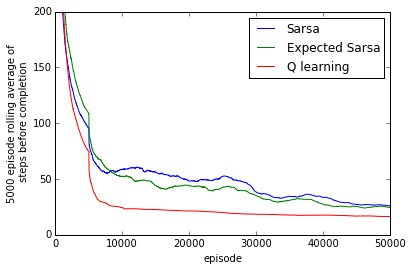

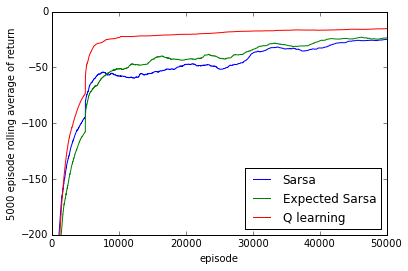

In [7]:
# plot the results
smoothing_size = 5000

x = np.arange(NbEpisodes)
timesteps_avg_Sarsa = pandas.rolling_mean(timesteps_Sarsa, smoothing_size, min_periods=1)
timesteps_avg_exp_Sarsa = pandas.rolling_mean(timesteps_exp_Sarsa, smoothing_size, min_periods=1)
timesteps_avg_Qlearning = pandas.rolling_mean(timesteps_Qlearning, smoothing_size, min_periods=1)

returns_avg_Sarsa = pandas.rolling_mean(returns_Sarsa, smoothing_size, min_periods=1)
returns_avg_exp_Sarsa = pandas.rolling_mean(returns_exp_Sarsa, smoothing_size, min_periods=1)
returns_avg_Qlearning = pandas.rolling_mean(returns_Qlearning, smoothing_size, min_periods=1)

plt.plot(x, timesteps_avg_Sarsa, label='Sarsa')
plt.plot(x, timesteps_avg_exp_Sarsa, label='Expected Sarsa')
plt.plot(x, timesteps_avg_Qlearning, label='Q learning')
plt.legend(loc='upper right')
plt.xlabel('episode')
plt.ylabel('%s episode rolling average of \n steps before completion' %smoothing_size)
plt.ylim([0, 200])
plt.savefig('%s episode rolling average of \n steps before completion.png' %(NbEpisodes))
plt.show()

plt.plot(x, returns_avg_Sarsa, label='Sarsa')
plt.plot(x, returns_avg_exp_Sarsa, label='Expected Sarsa')
plt.plot(x, returns_avg_Qlearning, label='Q learning')
plt.legend(loc='lower right')
plt.xlabel('episode')
plt.ylabel('%s episode rolling average of return' %smoothing_size)
plt.ylim([-200, 0])
plt.savefig('%s episode rolling average of return.png' %(NbEpisodes))
plt.show()

#### Analysis

Upon analysis of the graphs, we notice that the Expected Sarsa (green) has a better performance than Traditional Sarsa under the same parameters. It indeed has a lower number of steps, on average, than the traditional Sarsa before completing the task, therefore confirming *Hypothesis 2* of the article.

However, we can also notice that the Q-learning approach is doing better than the two Sarsa methods under the provided parameters and environment. The article doesn't explore this type of comparison for this type of problem.